In [1]:
!pip install wandb -qU

In [2]:
import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby


import wandb
from wandb.keras import WandbCallback

2024-02-15 16:05:50.148843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 16:05:50.148956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 16:05:50.266705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.__version__

'2.15.0'

In [4]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
dataset_path = '/kaggle/input/dataset1/train.tsv'
image_dir = '/kaggle/input/dataset1/test/'

dataset = pd.DataFrame(data=pd.read_csv(dataset_path, sep='\t', header=None)).dropna()

image_paths = dataset[0]
image_texts = dataset[1]

In [6]:
list(image_paths[:10]), list(image_texts[:10])

(['aa1.png',
  'aa1007.png',
  'aa101.png',
  'aa1012.png',
  'aa1013.png',
  'aa1017.png',
  'aa1018.png',
  'aa1019.png',
  'aa102.png',
  'aa1021.png'],
 ['Молдова',
  'продолжила борьбу',
  'разработанные',
  'Плачи',
  'Гимны богам',
  '(вспомнить',
  'миф',
  'созда-',
  'Даже работа',
  'людей).'])

In [7]:
alphabets = ' !"%\'()+,-./0123456789:;=?R[]bcehioprstuxy«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'
vocab = set("".join(map(str, image_texts))) #list(alphabets)
print(sorted(vocab))

[' ', '!', '"', '%', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'R', '[', ']', 'b', 'c', 'e', 'h', 'i', 'o', 'p', 'r', 's', 't', 'u', 'x', 'y', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '№']


In [8]:
len(vocab)

107

In [9]:
max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

40

In [10]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char)+1)
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list)+1)[0]
    

In [11]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([ 57,  88,  85,  78,  88,  76,  74, 108, 108, 108, 108, 108, 108,
       108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
       108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
       108], dtype=int32)

In [12]:
train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

In [13]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(image_dir+img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])

    return {"image": img, "label": label}

In [14]:
# process_single_sample('mjsynth_sample/362_interpreter_40330.jpg', [1,2,3,4])

In [15]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [16]:
wandb.init(project="HWTR v1")

wandb: Currently logged in as: prcstak. Use `wandb login --relogin` to force relogin


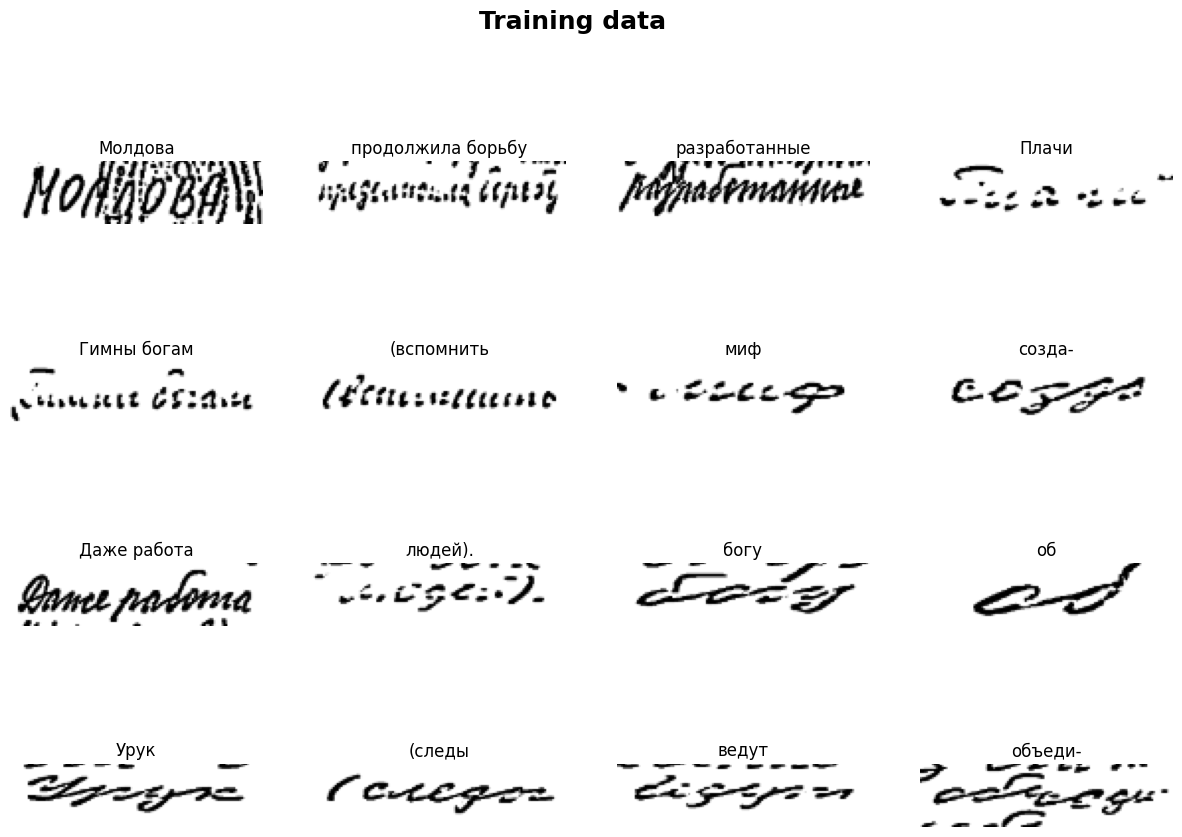

In [17]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()


wandb.log({"train_data": train_data_fig})

In [23]:
## Ref: https://keras.io/examples/vision/captcha_ocr/

def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length,
            ignore_longer_outputs_than_inputs=True
        ),
        1,
    )

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [36]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p < len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [34]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

#         orig_texts = []

#         for label in self.batch_labels:
#             orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)


In [31]:
def train(epochs):
    
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 2, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)


    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)

    print(model.summary())
    file_path = "C_LSTM_best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

    callbacks_list = [checkpoint, 
                      WandbCallback(monitor="val_loss", 
                                    mode="min", 
                                    log_weights=True),
                      PlotPredictions(frequency=1),
                      EarlyStopping(patience=3, verbose=1)]
    with tf.device('/gpu:0'):
        history = model.fit(train_dataset, 
                            epochs = epochs,
                            validation_data=validation_dataset,
                            verbose = 1,
                            callbacks = callbacks_list,
                            shuffle=True)
    
    return model

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 32, 128, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 16, 64, 32)           0         ['conv2d_42[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 16, 64, 64)           18496     ['max_pooling2d_24[0][0]

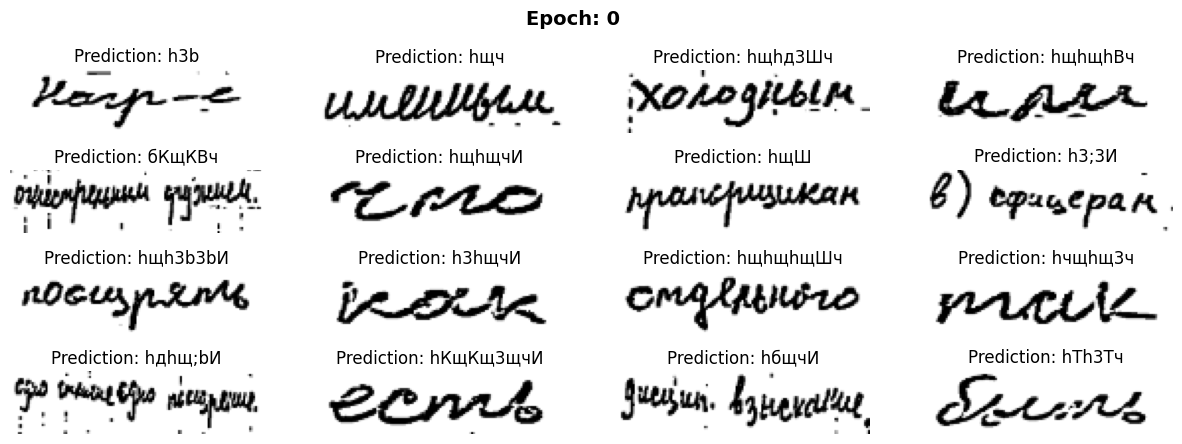

255/255 [==============================] - 52s 178ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/30
254/255 [============================>.] - ETA: 0s - loss: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
8/8 [==============================] - 1s 6ms/step


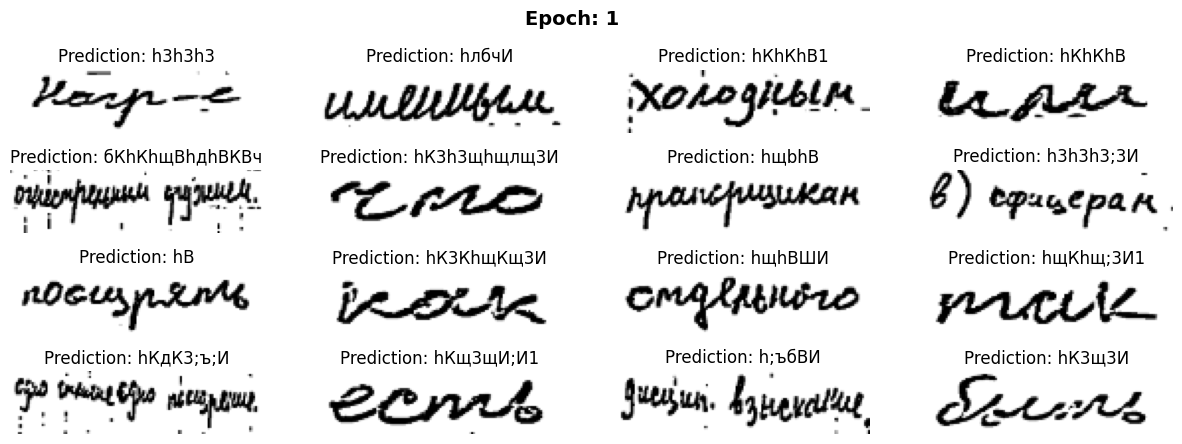

255/255 [==============================] - 44s 171ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
254/255 [============================>.] - ETA: 0s - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000
8/8 [==============================] - 1s 6ms/step


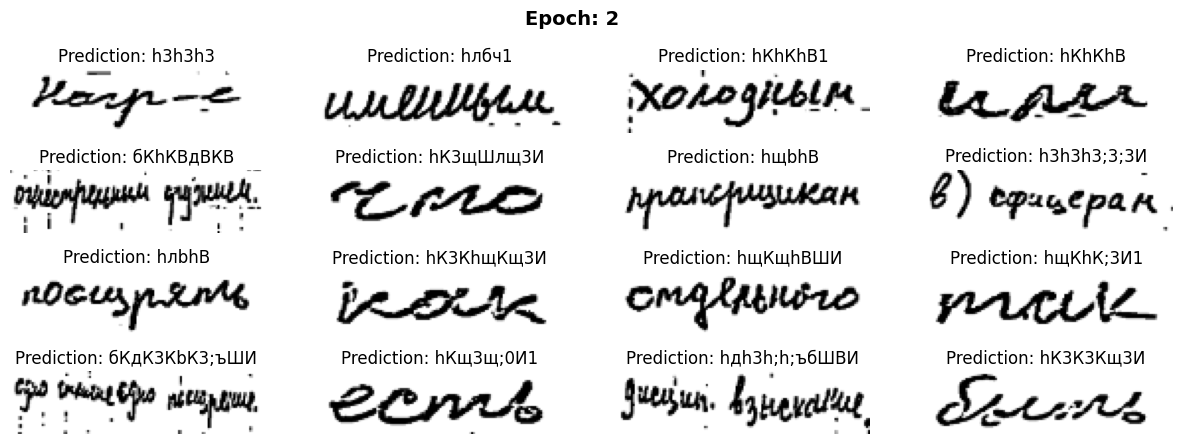

255/255 [==============================] - 44s 172ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/30
254/255 [============================>.] - ETA: 0s - loss: 0.0000e+00
Epoch 4: val_loss did not improve from 0.00000
8/8 [==============================] - 1s 6ms/step


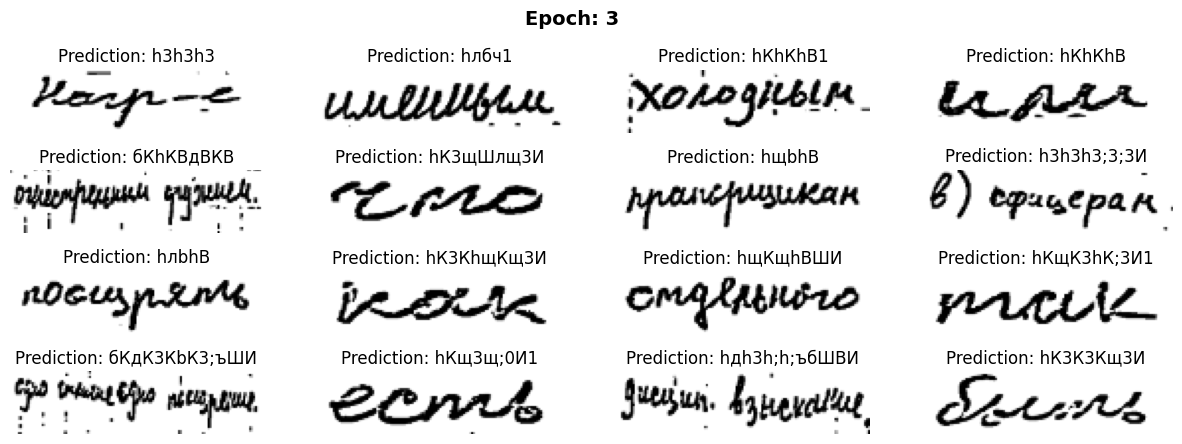

255/255 [==============================] - 44s 172ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4: early stopping


In [37]:
model = train(epochs=30)

In [ ]:
model.load_weights('C_LSTM_best.hdf5')

In [ ]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()




In [ ]:
len(figures_list)

In [ ]:
wandb.log({"prediction_for_each_epoch": [wandb.Image(fig, caption="epoch_"+str(i)) for i, fig in enumerate(figures_list)]})

In [33]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig , ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()


NameError: name 'prediction_model' is not defined

In [ ]:
wandb.log({"prediction_best_epoch": fig})

In [ ]:
## results can be improved with finetuning and including more data :)